In [17]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import torch.nn.functional as F


In [18]:
def display_spectrogram(data):
    plt.imshow(data, aspect='auto', cmap='inferno')
    plt.colorbar()
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()


In [19]:
from pathlib import Path

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128


class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, folder, files, crop_frames):
        super().__init__()
        self.folder = Path(folder)
        self.df = pd.DataFrame({'file_name': files})
        self.crop_frames = crop_frames

    def __len__(self):
        return len(self.df)
    
    def complete_audio(self, lms, dont_tfms=False):
        # Trim or pad
        l = lms.shape[-1]
        if l > self.crop_frames:
            start = np.random.randint(l - self.crop_frames) if self.random_crop else 0
            lms = lms[..., start:start + self.crop_frames]
        elif l < self.crop_frames:
            pad_param = []
            for i in range(len(lms.shape)):
                pad_param += [0, self.crop_frames - l] if i == 0 else [0, 0]
            lms = F.pad(lms, pad_param, mode='constant', value=0)
        lms = lms.to(torch.float)
        
        # Normalize
        if hasattr(self, 'norm_stats'):
            lms = (lms - self.norm_stats[0]) / self.norm_stats[1]
            
        return lms
    
    def get_audio_file(self, filename):
        # Load the audio file using librosa
        y, sr = librosa.load(filename, sr=None)
        # Convert the audio waveform to a spectrogram
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        # Convert the spectrogram to decibel scale
        lms = librosa.power_to_db(spectrogram, ref=np.max)
        return torch.tensor(lms)
    
    def get_audio(self, index):
        filename = self.folder/self.df.file_name.values[index]
        return self.get_audio_file(filename)
    
    def __getitem__(self, index):
        lms = self.get_audio(index)
        return self.complete_audio(lms)
    
def get_files_recursive(root_folder):
    root_path = Path(root_folder)
    return [str(file.relative_to(root_folder)) for file in root_path.rglob('*.mp3')]


torch.Size([128, 4096])
torch.Size([128, 4096])
tensor([[-80., -80., -80.,  ...,   0.,   0.,   0.],
        [-80., -80., -80.,  ...,   0.,   0.,   0.],
        [-80., -80., -80.,  ...,   0.,   0.,   0.],
        ...,
        [-80., -80., -80.,  ...,   0.,   0.,   0.],
        [-80., -80., -80.,  ...,   0.,   0.,   0.],
        [-80., -80., -80.,  ...,   0.,   0.,   0.]])


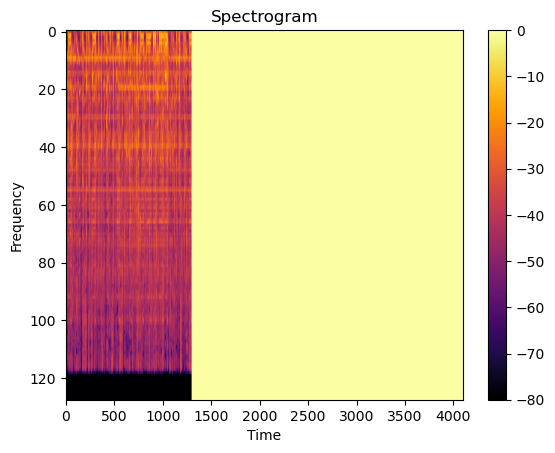

RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x4096 and 5x5)

In [20]:


class ContextEncoder(nn.Module):
    def __init__(self):
        super(ContextEncoder, self).__init__()
        # Define the context encoder architecture (e.g., a Vision Transformer)
        self.encoder = nn.Sequential(
            torch.nn.Linear(5,5),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        # Define the predictor architecture
        self.predictor = nn.Sequential(
            torch.nn.Linear(5,5),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.predictor(x)

class TargetEncoder(nn.Module):
    def __init__(self):
        super(TargetEncoder, self).__init__()
        # Define the target encoder architecture (e.g., a Vision Transformer)
        self.encoder = nn.Sequential(
            torch.nn.Linear(5,5),
            torch.nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

class IJEPA(nn.Module):
    def __init__(self):
        super(IJEPA, self).__init__()
        self.context_encoder = ContextEncoder()
        self.predictor = Predictor()
        self.target_encoder = TargetEncoder()

    def forward(self, context, target):
        context_embedding = self.context_encoder(context)
        predicted_target_embedding = self.predictor(context_embedding)
        target_embedding = self.target_encoder(target)
        return predicted_target_embedding, target_embedding

# Define the loss function (e.g., Mean Squared Error)
loss_function = nn.MSELoss()

# Instantiate the I-JEPA model
model = IJEPA()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

dataset_path = './data2'
sample_len = 4096


# if os.path.exists('spectrogram_dataset.pth'):
#     dataset = torch.load('spectrogram_dataset.pth')

# else:
#     dataset = SpectrogramDataset(
#         folder=dataset_path,
#         files=get_files_recursive(dataset_path),  # Assuming you've imported the get_files function
#         crop_frames=sample_len
#     )
#     torch.save(dataset, 'spectrogram_dataset.pth')

dataset = SpectrogramDataset(
        folder=dataset_path,
        files=get_files_recursive(dataset_path),  # Assuming you've imported the get_files function
        crop_frames=sample_len
    )

print(dataset[0].shape)
print(dataset[1].shape)
dataloader = DataLoader(
    dataset[0],
    batch_size=50
)


print(dataset[1])
display_spectrogram(dataset[1])


# Training loop
for epoch in range(epochs):
    for context in dataloader:
        predicted_target_embedding, target_embedding = model(context, context)
        loss = loss_function(predicted_target_embedding, target_embedding)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
